# Device 

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='3'

In [2]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def device_info():
    print('Using device:', device)
    print()

    #Additional Info when using cuda
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
        
        
device_info()

Using device: cuda

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
[torch.cuda.device(i) for i in range(torch.cuda.device_count())]

# Text transformer

In [4]:
ALPHABET='abcdefghijklmnopqrstuvwxyz'
EXT_ALPHABET='^ '+ALPHABET

class TextTransformer:
    def __init__(self,alphabet):
        self.char_map={ c:i for i, c in enumerate(list(alphabet))}
        self.int_map={ i:c for i, c in enumerate(list(alphabet))}

    def text_to_int(self, text):
        int_seq=[]
        for c in text:
            int_seq.append(0.0+self.char_map[c])
        return int_seq

    def int_to_text(self, int_seq):
        text=''
        for i in int_seq:
            text+=self.int_map[i]
        return text

text_transform=TextTransformer(EXT_ALPHABET)

text_transform.char_map

{'^': 0,
 ' ': 1,
 'a': 2,
 'b': 3,
 'c': 4,
 'd': 5,
 'e': 6,
 'f': 7,
 'g': 8,
 'h': 9,
 'i': 10,
 'j': 11,
 'k': 12,
 'l': 13,
 'm': 14,
 'n': 15,
 'o': 16,
 'p': 17,
 'q': 18,
 'r': 19,
 's': 20,
 't': 21,
 'u': 22,
 'v': 23,
 'w': 24,
 'x': 25,
 'y': 26,
 'z': 27}

# WER CER

In [5]:
import numpy as np

def calc_wer(target_text: str, pred_text: str):
    target=target_text.split(' ')
    pred=pred_text.split(' ')

    t_len,p_len=len(target),len(pred)

    D=np.zeros([t_len+1,p_len+1])
    D[0]=np.linspace(0,p_len,p_len+1)
    D[:,0]=np.linspace(0,t_len,t_len+1)

    for i in range(1,t_len+1):
        for j in range(1,p_len+1):
            if target[i-1]==pred[j-1]:
                D[i,j]=D[i-1,j-1]
            else:
                substitution=D[i-1,j-1]+1
                deletions=D[i-1,j]+1
                insertions=D[i,j-1]+1
                D[i,j]=min(substitution,deletions,insertions)

    return D[t_len,p_len]/t_len


def calc_cer(target_text: str, pred_text: str):
    target=list(target_text)
    pred=list(pred_text)

    t_len,p_len=len(target),len(pred)

    D=np.zeros([t_len+1,p_len+1])
    D[0]=np.linspace(0,p_len,p_len+1)
    D[:,0]=np.linspace(0,t_len,t_len+1)

    for i in range(1,t_len+1):
        for j in range(1,p_len+1):
            if target[i-1]==pred[j-1]:
                D[i,j]=D[i-1,j-1]
            else:
                substitution=D[i-1,j-1]+1
                deletions=D[i-1,j]+1
                insertions=D[i,j-1]+1
                D[i,j]=min(substitution,deletions,insertions)

    return D[t_len,p_len]/t_len

# CTC

In [6]:
import re
from collections import defaultdict,Counter

BLANK_CHAR='^'
BLANK_IDX=0

def ctc_greedy_decoder(output, labels, input_lengths, label_lengths):
    #output shape (batch,time,n_classes)
    tt = TextTransformer(EXT_ALPHABET)
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(tt.int_to_text(labels[i][:label_lengths[i]].tolist()))

        for j, index in enumerate(args[:input_lengths[i]]):
            if index != BLANK_IDX:
                if j != 0 and index == args[j-1]:
                    continue
                decode.append(index.item())
        dec_text=tt.int_to_text(decode)
        decodes.append(dec_text)
    return decodes, targets

# Define model

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class Pointwise_conv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Conv1d(in_c, out_c, 1)
        nn.init.kaiming_uniform_(self.conv.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        return self.conv(x)


class C_block(nn.Module):
    def __init__(self, in_c, out_c, kernel_size, padding='same'):
        super().__init__()
        self.conv = nn.Conv1d(in_c, out_c, kernel_size,padding=padding)
        self.batch_norm = nn.BatchNorm1d(out_c)
        
        nn.init.kaiming_uniform_(self.conv.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = F.relu(x)

        return x


class R_block(nn.Module):
    def __init__(self, in_c, out_c, kernel_size, stride, activate=True):
        super().__init__()
        self.activate = activate
        
        padding='same' if stride==1 else kernel_size//2
        
        self.conv_depth = nn.Conv1d(
            in_c, in_c, 
            kernel_size, stride=stride,
            padding=padding, groups=in_c
        )
        self.conv_point = nn.Conv1d(in_c, out_c, 1)
        self.batch_norm = nn.BatchNorm1d(out_c)
        
        nn.init.kaiming_uniform_(self.conv_depth.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.conv_point.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        x = self.conv_depth(x)
        x = self.conv_point(x)
        x = self.batch_norm(x)
        if(self.activate):
            x = F.relu(x)
            
        return x


class B_block(nn.Module):
    def __init__(self, R_size, in_c, out_c, kernel_size, stride, residual=True):
        super().__init__()
#         self.residual=residual
        self.conv_pw = Pointwise_conv(in_c, out_c)
        self.batch_norm = nn.BatchNorm1d(out_c)
        self.R = nn.Sequential(
            *self.generate_R_part(R_size, in_c, out_c, kernel_size, stride)
        )
        
        
    def forward(self, x):
        x_add = self.conv_pw(x)
        x_add = self.batch_norm(x_add)
        x = self.R(x)
        x = x+x_add
        x = F.relu(x)

        return x

#     def forward(self, x):
#         _x = self.R(x)
#         if self.residual:
#             x_add = self.conv_pw(x)
#             x_add = self.batch_norm(x_add)
#             _x = _x+x_add
#         _x = F.relu(_x)

#         return _x

    def generate_R_part(self, R_size, in_c, out_c, kernel_size,stride):
        r_list = []
        for i in range(R_size):
            if i == 0:
                r_list.append(
                    R_block(
                        in_c,
                        out_c,
                        kernel_size,
                        stride
                    )
                )
            else:
                r_list.append(
                    R_block(
                        out_c,
                        out_c,
                        kernel_size,
                        stride,
                        activate=False
                    )
                )
        return r_list


class QuartzNet(nn.Module):
    def __init__(self, params):
        super().__init__()

        c_params = params['c_params']
        b_params = params['b_params']
        b_size = params['b_size']

        self.C_1 = R_block(
            c_params['c_1']['in'],
            c_params['c_1']['out'],
            c_params['c_1']['kernel'],
            c_params['c_1']['stride'],
        )

        self.B = nn.Sequential(
            *[B_block(b_size, p['in'], p['out'], p['kernel'], p['stride']) for p in b_params]
        )

        self.C_2 = R_block(
            c_params['c_2']['in'],
            c_params['c_2']['out'],
            c_params['c_2']['kernel'],
            c_params['c_2']['stride']
        )
        self.C_3 = C_block(
            c_params['c_3']['in'],
            c_params['c_3']['out'],
            c_params['c_3']['kernel'],
            c_params['c_3']['stride']
        )
        self.C_4 = C_block(
            c_params['c_4']['in'],
            c_params['c_4']['out'],
            c_params['c_4']['kernel'],
            c_params['c_4']['stride']
        )

    def forward(self, x):
        sizes = x.size()  # (batch,chanel,feature,time)
        x = x.view(sizes[0], sizes[1] * sizes[2],sizes[3])  # (batch,chanel,time)
        x = self.C_1(x)
        x = self.B(x)
        x = self.C_2(x)
        x = self.C_3(x)
        x = self.C_4(x)

        return x

# Librispeech

In [9]:
class SpectrogramTransform(object):
    """Transform waveform to Mel spectrogram"""
    
    def __init__(self, sample_rate, n_mels):
        self.audio_transform=torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels)

    def __call__(self, wav):
        spec=self.audio_transform(wav).squeeze(0).transpose(0, 1)
        return spec
    
    
class LabelTransform(object):
    """Tokenize label text"""
    
    def __init__(self, alphabet):
        self.transformer=TextTransformer(alphabet)

    def __call__(self, text):
        
        text=text.lower()
        text = re.sub(r'[^a-z ]', '', text)
        text=re.sub('  +',' ',text).strip()
        token=torch.tensor(
            self.transformer.text_to_int(text)
        )
        return token
    
    
def speech_collator(data):
    """Spectrograms and labels padding
    """
    
    spectrograms=[]
    labels=[]
    label_lengths=[]
    input_lengths=[]
    for spec, label_token in data:
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(label_token.shape[0])
        
        spectrograms.append(spec)
        labels.append(label_token)
        
    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True, padding_value=0.0).unsqueeze(1).transpose(2, 3) #shape: (batch_size,1,n_mels,spec_len)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=0.0) #shape (batch_size, label_len)
    
    return spectrograms, labels, input_lengths, label_lengths
    

In [10]:
import os
from typing import Tuple, Union
from pathlib import Path

import torchaudio
import torch
from torch import Tensor
from torch.utils.data import Dataset
from torchaudio.datasets.utils import (
    download_url,
    extract_archive,
)

URL = "dev-clean"
FOLDER_IN_ARCHIVE = "LibriSpeech"


def load_librispeech_item(fileid: str,
                          path: str,
                          ext_audio: str,
                          ext_txt: str) -> Tuple[Tensor, int, str]:
    speaker_id, chapter_id, utterance_id = fileid.split("-")

    file_text = speaker_id + "-" + chapter_id + ext_txt
    file_text = os.path.join(path, speaker_id, chapter_id, file_text)

    fileid_audio = speaker_id + "-" + chapter_id + "-" + utterance_id
    file_audio = fileid_audio + ext_audio
    file_audio = os.path.join(path, speaker_id, chapter_id, file_audio)

    # Load audio
    waveform, sample_rate = torchaudio.load(file_audio)

    # Load text
    with open(file_text) as ft:
        for line in ft:
            fileid_text, transcript = line.strip().split(" ", 1)
            if fileid_audio == fileid_text:
                break
        else:
            # Translation not found
            raise FileNotFoundError("Translation not found for " + fileid_audio)

    return waveform ,sample_rate, transcript


class LIBRISPEECH(Dataset):
    """Create a Dataset for LibriSpeech.

    Args:
        root (str or Path): Path to the directory where the dataset is found or downloaded.
        url (str, optional): The URL to download the dataset from,
            or the type of the dataset to dowload.
            Allowed type values are ``"dev-clean"``, ``"dev-other"``, ``"test-clean"``,
            ``"test-other"``, ``"train-clean-100"``, ``"train-clean-360"`` and
            ``"train-other-500"``. (default: ``"train-clean-100"``)
        folder_in_archive (str, optional):
            The top-level directory of the dataset. (default: ``"LibriSpeech"``)
        download (bool, optional):
            Whether to download the dataset if it is not found at root path. (default: ``False``).
    """

    _ext_txt = ".trans.txt"
    _ext_audio = ".flac"

    def __init__(self,
                 transform,
                 target_transform,
                 root: Union[str, Path],
                 url: str = URL,
                 folder_in_archive: str = FOLDER_IN_ARCHIVE,
                 download: bool = False) -> None:
        
        self.transform=transform
        self.target_transform=target_transform
        

        if url in [
            "dev-clean",
            "dev-other",
            "test-clean",
            "test-other",
            "train-clean-100",
            "train-clean-360",
            "train-other-500",
        ]:

            ext_archive = ".tar.gz"
            base_url = "http://www.openslr.org/resources/12/"

            url = os.path.join(base_url, url + ext_archive)

        # Get string representation of 'root' in case Path object is passed
        root = os.fspath(root)

        basename = os.path.basename(url)
        archive = os.path.join(root, basename)

        basename = basename.split(".")[0]
        folder_in_archive = os.path.join(folder_in_archive, basename)

        self._path = os.path.join(root, folder_in_archive)

#         if download:
#             if not os.path.isdir(self._path):
#                 if not os.path.isfile(archive):
#                     checksum = _CHECKSUMS.get(url, None)
#                     download_url(url, root, hash_value=checksum)
#                 extract_archive(archive)

        self._walker = sorted(str(p.stem) for p in Path(self._path).glob('*/*/*' + self._ext_audio))

    def __getitem__(self, n: int) -> Tuple[Tensor, int, str]:
        """Load the n-th sample from the dataset.

        Args:
            n (int): The index of the sample to be loaded

        Returns:
            (Tensor, int, str, int, int, int):
            ``(waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id)``
        """
        fileid = self._walker[n]
        
        waveform, sample_rate, transcript=load_librispeech_item(
            fileid, self._path, self._ext_audio, self._ext_txt
        )
        
        spec=self.transform(waveform)
        label_token=self.target_transform(transcript)
        
        return spec, label_token
        


    def __len__(self) -> int:
        return len(self._walker)

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [11]:
import os

info = os.listdir('/nas/librispeech/librispeech/LibriSpeech')
print(*info,sep='\n')

dev-clean
train-clean-360
Untitled.ipynb
dev_clean.json
train_clean_360.json
test_clean.json
word10k
.ipynb_checkpoints
test-clean
LICENSE.TXT
README.TXT
CHAPTERS.TXT
SPEAKERS.TXT
BOOKS.TXT
test-other
cv-corpus-6.1-singleword
train-other-500
dev-other
train-clean-100


In [12]:
torch.manual_seed(1)
kwargs = {'num_workers': 1, 'pin_memory': False} if torch.cuda.is_available() else {}
# kwargs = {'num_workers': 2, 'pin_memory': True } if torch.cuda.is_available() else {}


transform=SpectrogramTransform(16000,64)
target_transform=LabelTransform(EXT_ALPHABET)

test_dataset=LIBRISPEECH(
    transform=transform,
    target_transform=target_transform,
    root='/nas/librispeech/librispeech/',
    url='test-clean',
    download=False
)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=lambda x: speech_collator(x),
    **kwargs
)


train_dataset=LIBRISPEECH(
    transform=transform,
    target_transform=target_transform,
    root='/nas/librispeech/librispeech/',
    url='train-clean-100',
    download=False
)

train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=lambda x: speech_collator(x),
    **kwargs
)

# WandB

In [14]:
import wandb


wandb.login()

wandb: Currently logged in as: whoami (use `wandb login --relogin` to force relogin)


True

# Train Test

In [15]:
class Counter():
    def __init__(self, start=0):
        self.count=start

    def step(self):
        self.count=self.count+1
        
    def get_value(self):
        return self.count

In [16]:
def log_text(pred,target):
    table = wandb.Table(columns=["Prediction", "Target"])
    table.add_data(pred,target)
    wandb.log({"Predictions_table":table}, commit=False)
    
def log_params(cer,wer,loss,step,p_type='train'):
    wandb.log({
        p_type+"_avg_cer":cer,
        p_type+"_avg_wer":wer,
        p_type+"_avg_loss":loss
    },step=step)

def log_batch_wandb(step,loss,output, labels, input_lengths, label_lengths,decoded_count=0):

    decoded_preds, decoded_targets = ctc_greedy_decoder(
        output, labels, input_lengths, label_lengths
    )

    test_cer, test_wer = [], []
    
    for j in range(len(decoded_preds)):
                test_cer.append(calc_cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(calc_wer(decoded_targets[j], decoded_preds[j]))
                
                if(j<decoded_count):
                    log_text(decoded_preds[j],decoded_targets[j])
                
    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)
    
    log_params(avg_cer,avg_wer,loss,step)

In [17]:
def train(model, device, train_loader, criterion, optimizer,counter: Counter,log_period=100):
    model.train()
    for batch_idx, _data in enumerate(train_loader):
                spectrograms, labels, input_lengths, label_lengths = _data 
                spectrograms, labels = spectrograms.to(device), labels.to(device)

                optimizer.zero_grad()

                output = model(spectrograms)  # (batch_size,n_class,time)
                output = F.log_softmax(output, dim=1)
                output = output.permute(2, 0, 1) # (time, batch_size, n_class)

                loss = criterion(output, labels, input_lengths, label_lengths)
            
                loss.backward()
                optimizer.step()
                counter.step()
                if batch_idx%log_period==0:
                    log_batch_wandb(
                        counter.get_value(),
                        loss.detach().item(), 
                        output.transpose(0, 1).detach(),
                        labels, 
                        input_lengths, 
                        label_lengths
                    )

                torch.cuda.empty_cache()


def test(model, device, test_loader, criterion, counter: Counter):
    test_loss = 0
    test_cer, test_wer = [], []

    model.eval()
    with torch.no_grad():
            for i, _data in enumerate(test_loader):
                    spectrograms, labels, input_lengths, label_lengths = _data 
                    spectrograms, labels = spectrograms.to(device), labels.to(device)

                    output = model(spectrograms)  # (batch_size,n_class,time)
                    output = F.log_softmax(output, dim=1)
                    output = output.permute(2, 0, 1) # (time, batch_size, n_class)
                    
                    loss = criterion(output, labels, input_lengths, label_lengths)
                    test_loss += loss.detach().item() / len(test_loader)

                    decoded_preds, decoded_targets = ctc_greedy_decoder(
                        output.transpose(0, 1), labels, input_lengths, label_lengths
                    )
                    for j in range(len(decoded_preds)):
                        test_cer.append(calc_cer(decoded_targets[j], decoded_preds[j]))
                        test_wer.append(calc_wer(decoded_targets[j], decoded_preds[j]))

                        if i==0 and j==0:
                            print('\n'+'_'*100)
                            print('target: ', decoded_targets[j])
                            print('pred: ', decoded_preds[j])


                    torch.cuda.empty_cache()

    counter.step()
    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)
    log_params(avg_cer,avg_wer,test_loss,counter.get_value(),'val')

# Create model

In [18]:
LEARNING_RATE=0.001
BLANK_IDX=0

b_params = [
    {
        'in': 256,
        'out': 256,
        'kernel': 33,
        'stride': 1
    },
    {
        'in': 256,
        'out': 256,
        'kernel': 39,
        'stride': 1
    },
    {
        'in': 256,
        'out': 512,
        'kernel': 51,
        'stride': 1
    },
    {
        'in': 512,
        'out': 512,
        'kernel': 63,
        'stride': 1
    },
    {
        'in': 512,
        'out': 512,
        'kernel': 75,
        'stride': 1
    },
]
c_params = {
    'c_1': {
        'in': 64,
        'out': 256,
        'kernel': 33,
        'stride': 2
    },
    'c_2': {
        'in': 512,
        'out': 512,
        'kernel': 87,
        'stride': 1
    },
    'c_3': {
        'in': 512,
        'out': 1024,
        'kernel': 1,
        'stride': 1
    },
    'c_4': {
        'in': 1024,
        'out': 28,
        'kernel': 1,
        'stride': 1
    },
}

parameters = {
    'c_params': c_params,
    'b_params': b_params,
    'b_size': 5
}

In [19]:
model=QuartzNet(parameters)


LAST_EPOCH=210

MODEL_PATH='./models/QuartzNet/test/test_data-model-'+str(LAST_EPOCH)
mp=torch.load(MODEL_PATH)
model.load_state_dict(mp['model_state_dict'])

model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9) #torch.optim.AdamW(model.parameters(),lr=LEARNING_RATE)

criterion = torch.nn.CTCLoss(blank=BLANK_IDX, reduction='sum').to(device)

# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10], gamma=0.1)

In [20]:
def parameters_info(model):
    print('Total parameters:',sum(p.numel() for p in model.parameters() if p.requires_grad),end='\n\n')

parameters_info(model)
device_info()

Total parameters: 6736852

Using device: cuda

Tesla K80
Memory Usage:
Allocated: 0.1 GB
Cached:    0.1 GB


In [23]:
from tqdm import tqdm

epochs=100
PATH='./models/QuartzNet/test3/'

counter=Counter(33100)

for epoch in tqdm(range(1, epochs + 1)):
        train(model, device, test_data_loader, criterion, optimizer,counter)
#         scheduler.step()
    
        if(epoch%10==0):
            test(model, device, test_data_loader, criterion,counter)
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion
                }, PATH+'test_data-model-'+str(LAST_EPOCH+epoch))



  9%|▉         | 9/100 [1:01:18<10:19:48, 408.67s/it]


____________________________________________________________________________________________________
target:  he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce
pred:       


 19%|█▉        | 19/100 [2:42:20<9:47:52, 435.46s/it]  


____________________________________________________________________________________________________
target:  he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce
pred:  h d  t    t  td  t   


 29%|██▉       | 29/100 [4:19:02<8:34:37, 434.90s/it] 


____________________________________________________________________________________________________
target:  he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce
pred:  h o ha the h the o he o he o the hd ho o the ha the od o o he h the o e a o


 39%|███▉      | 39/100 [5:57:23<7:15:54, 428.77s/it] 


____________________________________________________________________________________________________
target:  he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce
pred:  he i ea  ae a e a e  e a e  o a e a e a e a   e a ia


 49%|████▉     | 49/100 [7:34:00<6:02:46, 426.80s/it] 


____________________________________________________________________________________________________
target:  he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce
pred:  h e e e e i  e e en e o e a  e e a e a  a e e e  e e  e  e  i


 59%|█████▉    | 59/100 [9:11:29<4:54:24, 430.84s/it] 


____________________________________________________________________________________________________
target:  he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce
pred:  h  e ee e e a  e e e  a te a e a t a e a te e e a e a a e e e


 69%|██████▉   | 69/100 [10:50:04<3:43:54, 433.37s/it]


____________________________________________________________________________________________________
target:  he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce
pred:  he a e e e e e    e e an te e ee ee a ee e e e e e e e e e e 


 79%|███████▉  | 79/100 [12:27:57<2:32:32, 435.83s/it]


____________________________________________________________________________________________________
target:  he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce
pred:  h e a ee in ee e a  a a an e e ei e a e a e i e e ea e e e e  a a a e ae


 89%|████████▉ | 89/100 [14:05:47<1:18:46, 429.68s/it]


____________________________________________________________________________________________________
target:  he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce
pred:  h  e e e tee te an te an theo a an te on te on the a an e on e en ea a e e e te a a o a a a


 99%|█████████▉| 99/100 [15:45:51<07:10, 430.65s/it]   


____________________________________________________________________________________________________
target:  he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce
pred:  h e a e e e en e a ta e a e a the en e e e te a e e in  en e a a te e o e a a a ti a ie


100%|██████████| 100/100 [16:22:29<00:00, 589.49s/it]


In [ ]:
from matplotlib import pyplot as plt

def plot_s(spec):
    plt.figure(figsize=(20, 5))
    plt.imshow(spec.squeeze().log())
    plt.xlabel('Time', size=20)
    plt.ylabel('Mels', size=20)
    plt.show()

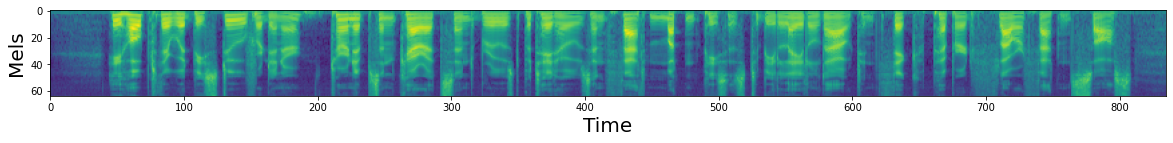

In [42]:
for b in test_data_loader:
    plot_s(b[0])
    break
    

In [28]:
def dec(labels,label_lengths):
    for i,l in enumerate(labels):
        print(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
        print()

